In [1]:
import geopandas as gpd
from rasterio.crs import CRS
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.optimize import least_squares
from variogram import (remove_trend,
                       get_emp_variogram,
                       bin_variogram)

# Inspect the Sample Data

In [2]:
gdf = gpd.read_file('california_gnss_stations.geojson')
gdf.head()

,ID,mean_residual,std_residual,med_residual,Lat,Lon,Lat_rounded,Lon_rounded,geometry
0,7ODM,5.309029,0.815358,5.198193,34.1164,-117.0932,34,-117,POINT (-117.09320 34.11640)
1,ACSB,4.890550,0.877273,4.862449,33.2743,-117.4449,33,-117,POINT (-117.44490 33.27430)
2,ACSX,4.658550,0.723727,4.637621,33.2743,-117.4449,33,-117,POINT (-117.44490 33.27430)
3,AERO,5.159740,0.773046,5.102750,32.8075,-117.1244,32,-117,POINT (-117.12440 32.80750)
4,AGMT,4.713157,0.805090,4.701313,34.5943,-116.4294,34,-116,POINT (-116.42940 34.59430)


<AxesSubplot:>

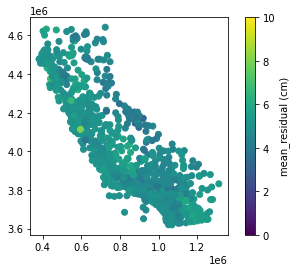

In [3]:
# Switch to UTM zone 10 for California; currently in epsg 4326
gdf = gdf.to_crs(CRS.from_epsg(32610))
column = 'mean_residual'
gdf.plot(column=column, 
         legend=True, 
         legend_kwds={'label':f'{column} (cm)'}, 
         vmin=0, 
         vmax=10)

# Prep Data for Analysis

Remove the `nan` values.

In [4]:
x = gdf.geometry.map(lambda geo: geo.coords[0][0]).values / 1e3
y = gdf.geometry.map(lambda geo: geo.coords[0][1]).values / 1e3
z = gdf[column].values

# Remove nan values if any
mask = np.isnan(z)
x = x[~mask]
y = y[~mask]
z = z[~mask]

n = len(x)
print('# of samples: ', n)
print('Total pairs: ', n * (n-1) // 2)

# of samples:  1068
Total pairs:  569778


Even if we have small number of samples $n$, the pairs increase with $O(n^2)$, so the computational load can be problematic. That's why we show the `total pairs` above.

# De-trend (aka de-ramp)

Let's remove the trend (this also ensures our spatial distribution has zero mean).

In [5]:
z_detrended = remove_trend(x, y, z)

# Compute Empirical Variogram

In [6]:
dist, vario = get_emp_variogram(x, y, z_detrended, 
                                ## Can specify samples if dataset is large (random sample chosen)
                                #n_samples=1000
                                )

Text(0, 0.5, 'Frequency')

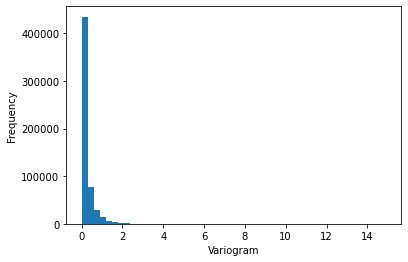

In [7]:
plt.hist(vario, bins=50)
plt.xlabel('Variogram')
plt.ylabel('Frequency')

Text(0, 0.5, 'Variogram')

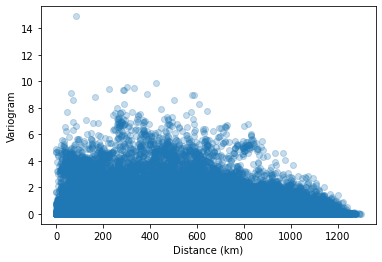

In [8]:
plt.scatter(dist, vario, alpha=.25)
plt.xlabel('Distance (km)')
plt.ylabel('Variogram')

# Bin the variogram

In [11]:
dist_binned, variogram_binned = bin_variogram(dist, vario,
                                              distance_range=[0, np.nanmax(dist) * .67],
                                              bins=50
                                              )

Text(0, 0.5, 'Variogram (binned)')

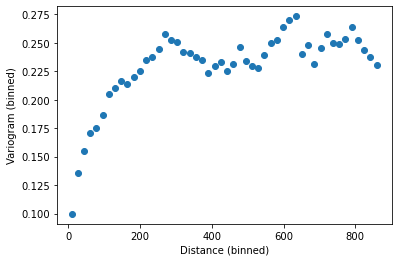

In [12]:
plt.scatter(dist_binned, variogram_binned)
plt.xlabel('Distance (binned)')
plt.ylabel('Variogram (binned)')

# Fit the variogram for Analysis

In [13]:
def exp_model(h: float, a: float, b: float) -> float:
    return b * (1 - np.exp(-h / a))

In [14]:
popt, pcov = curve_fit(exp_model, dist_binned, variogram_binned)

In [108]:
fitted_model = lambda h: exp_model(h, *popt)

Text(0, 0.5, 'Variogram (binned)')

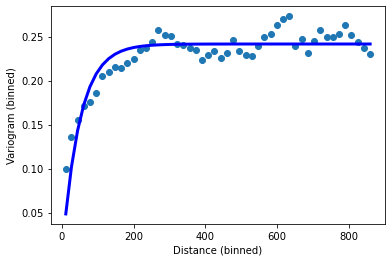

In [109]:
plt.scatter(dist_binned, variogram_binned)
plt.plot(dist_binned, fitted_model(dist_binned), c='blue', lw=3)
plt.xlabel('Distance (binned)')
plt.ylabel('Variogram (binned)')